In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [26]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
    df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
    return df

def clean_csv(df,time_variable,quantitative_variable):
    df = df[[time_variable, quantitative_variable]].copy()
    df.columns = ['ds','y']
    df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
    df = df.drop_duplicates(subset=['ds'])
    df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
    df = df.dropna(subset=['ds'])
    df = df.sort_values(by=['ds'])
    pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
    #if (pourcentage <= 2):
    #  df = df.dropna(subset=['y'])

    if(pourcentage < 25):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
    elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
    if(len(df) > 1000):
        supr = len(df) - 1000
        df = df[:-supr]
    return df, pourcentage

In [70]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [31]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 200
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [10]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Climat'

In [6]:
os.chdir('../../Datasets/Climat')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Climat'

In [7]:
!ls

M-data_Afghanistan.csv	    M-data_Benin.csv
M-data_Albania.csv	    M-data_Bolivia.csv
M-data_Algeria.csv	    M-data_Bosnia_H.csv
M-data_Andorra.csv	    M-data_Botswana.csv
M-data_Antigua_Barbada.csv  M-data_British_Virgin_Island.csv
M-data_Armenia.csv	    M-data_Burma.csv
M-data_Azerbaijan.csv	    M-data_Cameroon.csv
M-data_Bahamas.csv	    M-data_Colombia.csv
M-data_Baker_Island.csv     M-data_Costa_Rica.csv
M-data_Belgium.csv


In [17]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)
        
        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [71]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

M-data_Bahamas
Initial log joint probability = -5.23996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2637.51   0.000944642       274.495       0.514       0.514      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       2638.01   2.53215e-05       102.113   1.074e-07       0.001      254  LS failed, Hessian reset 
     199       2638.04   3.96153e-06       82.9965       2.939      0.2939      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       2638.05    2.6651e-05       77.9487   3.305e-07       0.001      354  LS failed, Hessian reset 
     299       2638.07   1.68209e-07       76.9283      0.2388      0.2388      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       2638.21   1.49168e-05       63.6817   1.086e-07       0.001      552  LS faile

M-data_Andorra
Initial log joint probability = -44.2343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1961.38   0.000174144       73.3375      0.2261      0.2261      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1965.3    0.00270075       61.5426           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        1966.1   0.000243837       231.243   8.377e-07       0.001      308  LS failed, Hessian reset 
     270        1966.9   7.77977e-05       81.1505   1.024e-06       0.001      429  LS failed, Hessian reset 
     299       1966.95   2.05008e-05       63.2235      0.6247      0.6247      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       1966.96   1.72583e-05       81.8922   2.628e-07       0.001      588  LS faile

M-data_Costa_Rica
Initial log joint probability = -2.36901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2916.08   0.000335562       93.0663           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2917   0.000633188       122.974      0.3022           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2917.01   6.59156e-06       71.4416   7.726e-08       0.001      296  LS failed, Hessian reset 
     210       2917.04   1.09159e-05        100.76   5.845e-08       0.001      350  LS failed, Hessian reset 
     287       2917.31   1.29025e-05        136.69   6.784e-08       0.001      506  LS failed, Hessian reset 
     299       2917.47   0.000796648       240.213       0.549           1      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alp

In [49]:
df

[            ds       y
 0   1887-05-01  24.758
 1   1887-06-01  26.902
 2   1887-07-01  28.106
 3   1887-08-01  27.844
 4   1887-09-01  26.937
 ..         ...     ...
 995 1970-04-01  25.273
 996 1970-05-01  25.619
 997 1970-06-01  27.377
 998 1970-07-01  28.384
 999 1970-08-01  28.719
 
 [1000 rows x 2 columns],
             ds       y
 0   1883-02-01  24.152
 1   1883-03-01  23.994
 2   1883-04-01  24.571
 3   1883-05-01  25.696
 4   1883-06-01  26.860
 ..         ...     ...
 995 1966-01-01  24.878
 996 1966-02-01  24.859
 997 1966-03-01  25.302
 998 1966-04-01  25.736
 999 1966-05-01  26.542
 
 [1000 rows x 2 columns],
             ds       y
 0   1871-01-01  21.704
 1   1871-02-01  21.119
 2   1871-03-01  21.750
 3   1871-04-01  20.687
 4   1871-05-01  18.368
 ..         ...     ...
 995 1953-12-01  22.932
 996 1954-01-01  22.203
 997 1954-02-01  22.008
 998 1954-03-01  21.475
 999 1954-04-01  21.126
 
 [1000 rows x 2 columns],
             ds       y
 0   1801-05-01  17.825
 1  

In [72]:
results_naive

DATA_SET_NAME        Method                  MAE  \
0                 M-data_Bahamas  Naive Method   0.2647522261097946   
1   M-data_British_Virgin_Island  Naive Method  0.23727713028895323   
2                 M-data_Bolivia  Naive Method  0.19677047108607082   
3                 M-data_Albania  Naive Method  0.40540154019217495   
4            M-data_Baker_Island  Naive Method  0.03855920960513485   
5                 M-data_Algeria  Naive Method  0.38673754967883556   
6                 M-data_Andorra  Naive Method  0.27626227271434217   
7              M-data_Azerbaijan  Naive Method   0.2753041176036695   
8                 M-data_Belgium  Naive Method  0.23948712231326538   
9                   M-data_Burma  Naive Method   0.2873652871904001   
10            M-data_Afghanistan  Naive Method  0.24953359346421167   
11               M-data_Cameroon  Naive Method  0.18589101277837558   
12                M-data_Armenia  Naive Method  0.43933206655470614   
13             M-data_Costa_Rica  Naive Method  0.10653777359305154   
14                  M-data_Benin  Naive Method   0.3013808754751404   
15               M-data_Bosnia_H  Naive Method  0.09554211857153123   
16               M-data_Botswana  Naive Method  0.35748553021391527   
17        M-data_Antigua_Barbada  Naive Method  0.21105358281462222   
18               M-data_Colombia  Naive Method   0.1370183900700942   

                     MSE                  RMSE  
0    0.09920698364257362   0.31497140130902934  
1     0.0910231648780354    0.3017004555482729  
2    0.05109031803855234    0.2260316748567606  
3    0.23662484438017475   0.48644099784061656  
4   0.002527254171679652  0.050271802948369096  
5    0.23353204543703796   0.48325153433490303  
6    0.12035403460321539    0.3469207900994338  
7    0.10856859113002862    0.3294974827370137  
8     0.0879483092042716   0.29656080186746125  
9    0.09892963654351128   0.31453081970374747  
10   0.08013568639734381    0.2830824727837169  
11  0.061489014244642724   0.24796978494292954  
12   0.26889046106755904    0.5185464888200083  
13  0.017246222562341124    0.1313248741188855  
14    0.1194010258816266    0.3455445353085859  
15   0.01156779388833611    0.1075536791018146  
16    0.1903250311247163   0.43626257130851404  
17  0.057401009778925614   0.23958507837285195  
18    0.0311675884487331   0.17654344634886082

In [73]:
results_prophet

DATA_SET_NAME          Method                   MAE  \
0                 M-data_Bahamas  Prophet Method  0.058689089307969095   
1   M-data_British_Virgin_Island  Prophet Method  0.061846012595361745   
2                 M-data_Bolivia  Prophet Method    0.0721576594545577   
3                 M-data_Albania  Prophet Method  0.042035704383359705   
4            M-data_Baker_Island  Prophet Method   0.03856650801353057   
5                 M-data_Algeria  Prophet Method  0.037275340882136826   
6                 M-data_Andorra  Prophet Method   0.06404961754419349   
7              M-data_Azerbaijan  Prophet Method   0.03693627391600057   
8                 M-data_Belgium  Prophet Method  0.053087513949163834   
9                   M-data_Burma  Prophet Method  0.040739031797529586   
10            M-data_Afghanistan  Prophet Method   0.03406129194718517   
11               M-data_Cameroon  Prophet Method   0.07054766742769114   
12                M-data_Armenia  Prophet Method   0.04005380165938313   
13             M-data_Costa_Rica  Prophet Method   0.06770288115554748   
14                  M-data_Benin  Prophet Method   0.07001286464800911   
15               M-data_Bosnia_H  Prophet Method   0.01695407123543184   
16               M-data_Botswana  Prophet Method   0.05204779273898716   
17        M-data_Antigua_Barbada  Prophet Method   0.06828773293418536   
18               M-data_Colombia  Prophet Method   0.11665249609619735   

                      MSE                  RMSE  
0   0.0063603433866970096   0.07975176102567899  
1    0.006342512963817557   0.07963989555378358  
2    0.008523129323276882   0.09232079572489008  
3   0.0028177480599529243   0.05308246471249168  
4   0.0025332655193485826  0.050331555900335355  
5   0.0021264254434843603  0.046113180799901024  
6    0.006007133321341165   0.07750569863784962  
7   0.0023168670750261934   0.04813384542113993  
8    0.004722481554573657    0.0687203139877406  
9   0.0028446038309135695   0.05333482756054968  
10  0.0020616403745886934    0.0454052901608248  
11   0.008503816689351053      0.09221614115409  
12   0.002592446015000575   0.05091606833800676  
13   0.007386133520287708    0.0859426176020239  
14   0.007968346019416327    0.0892655925842445  
15  0.0004953389037970714  0.022256210454546645  
16   0.004268225363291022   0.06533165667033879  
17   0.007001822135150547   0.08367689128517232  
18   0.022698560675150706    0.1506604150901978

In [74]:
results_prophet.to_csv(r'../../Resultats/Resultats_200/prophet_results_climat.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_200/naive_results_climat.csv', index = False)

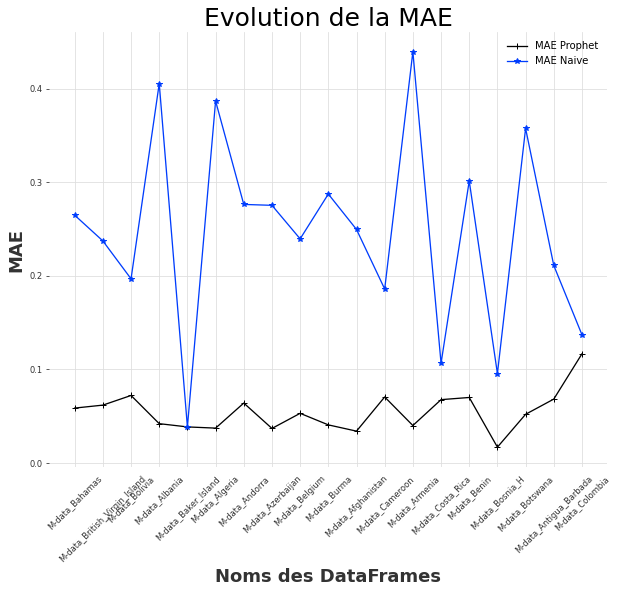

In [75]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

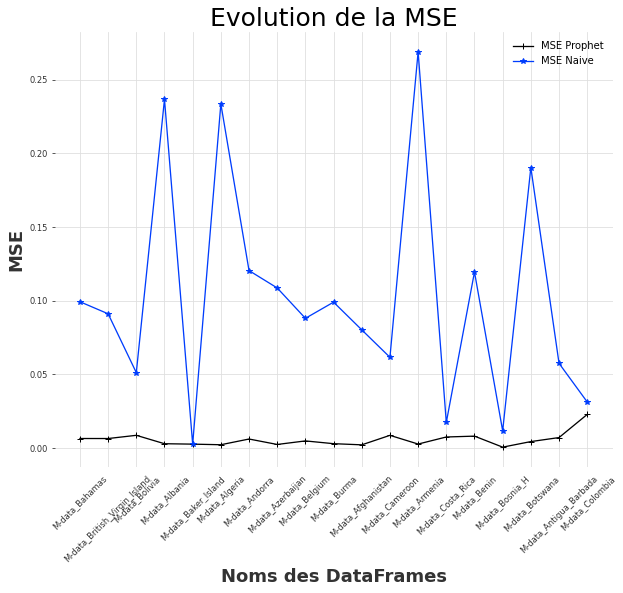

In [76]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

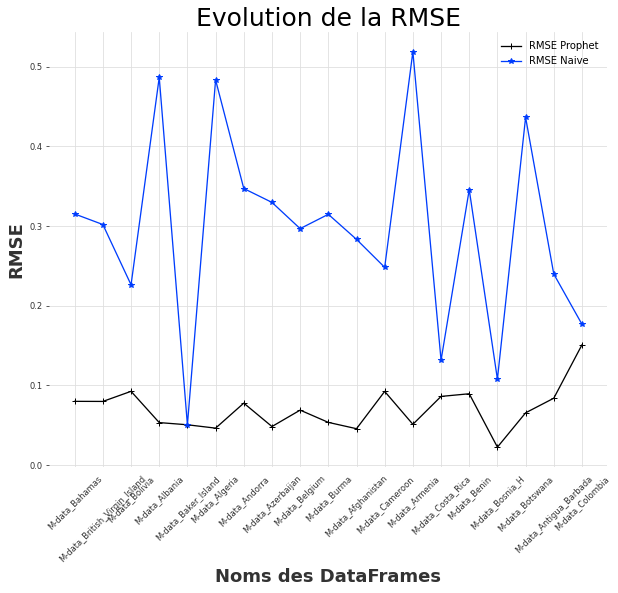

In [78]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

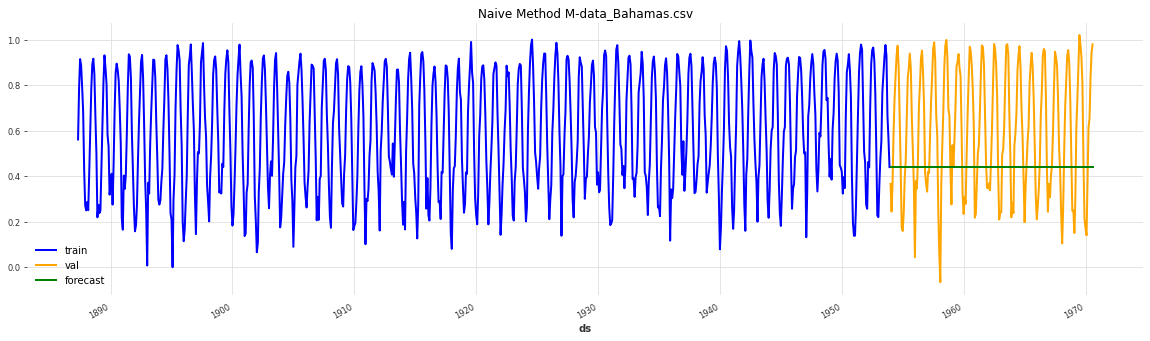

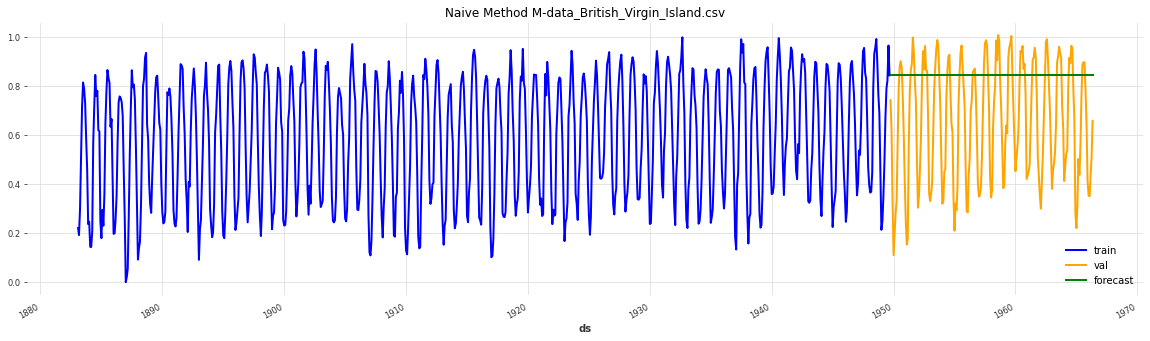

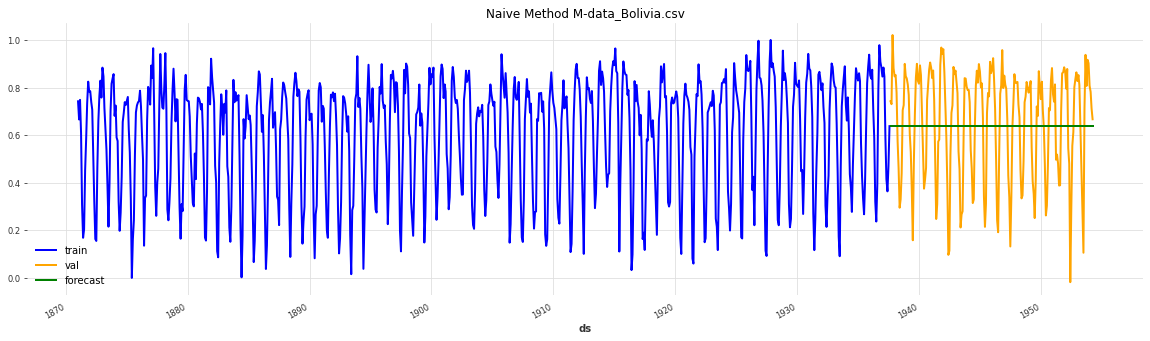

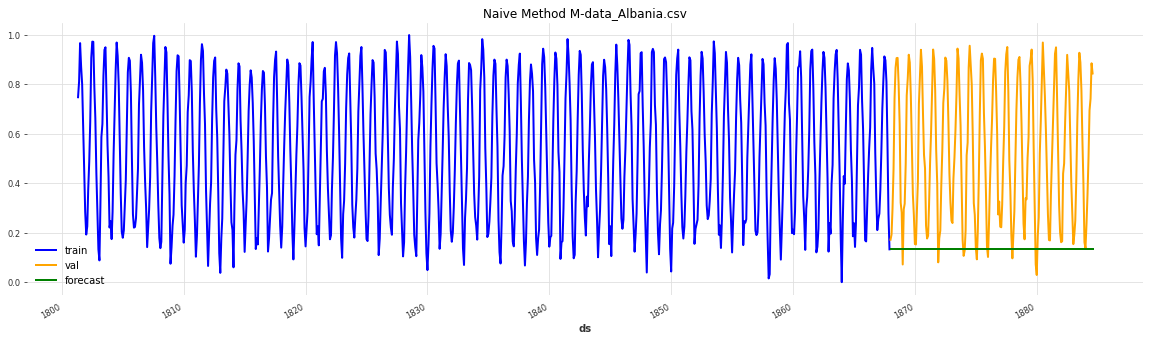

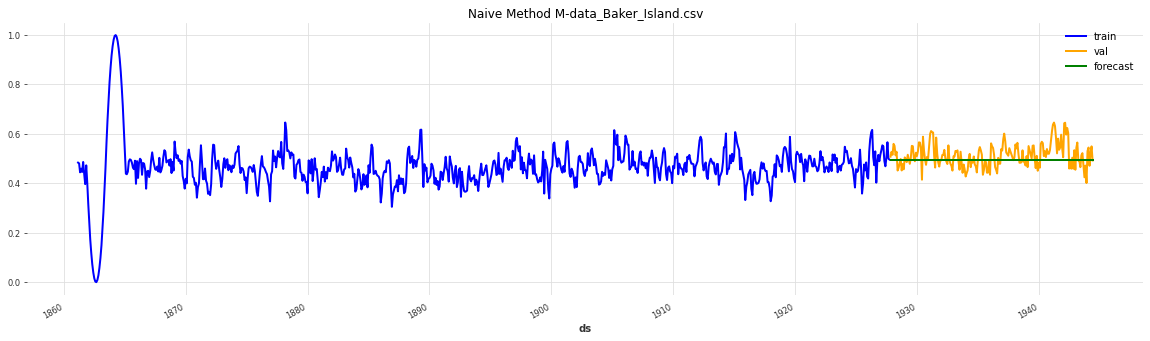

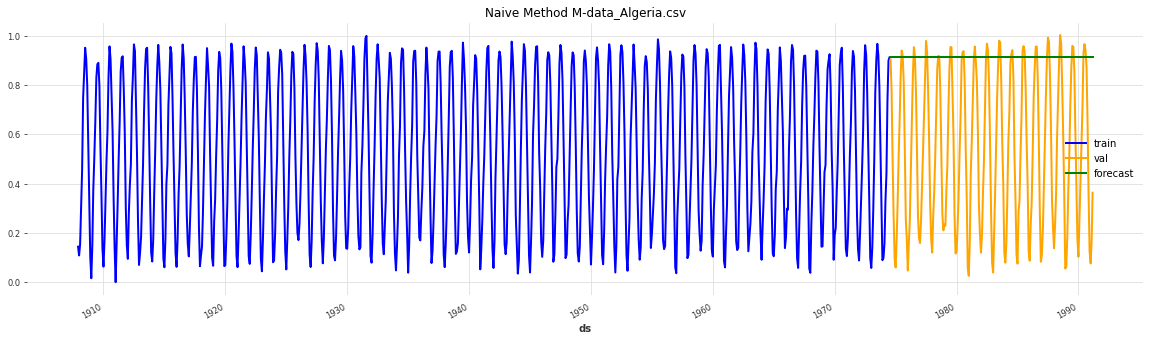

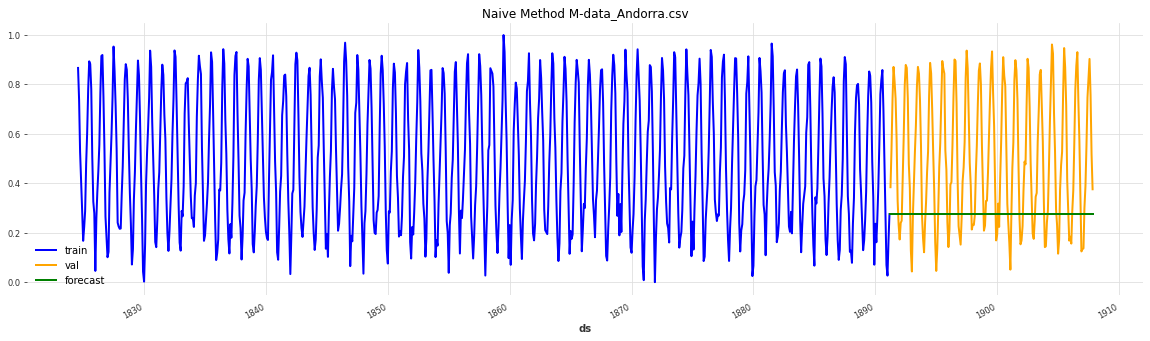

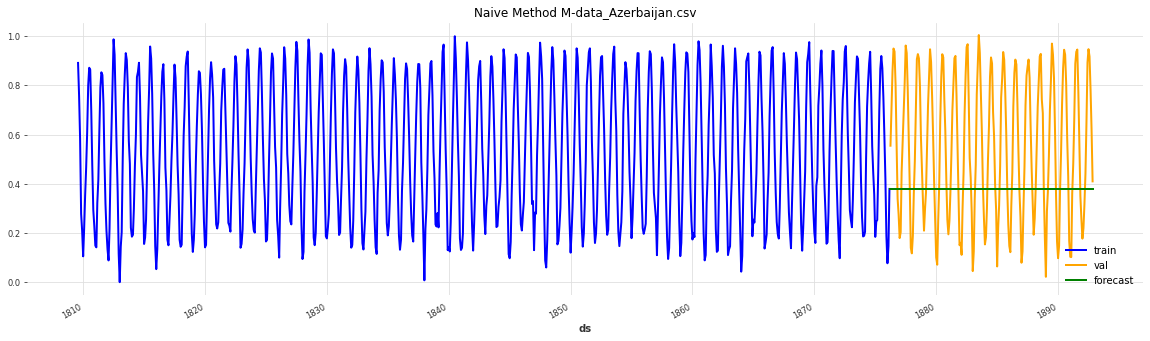

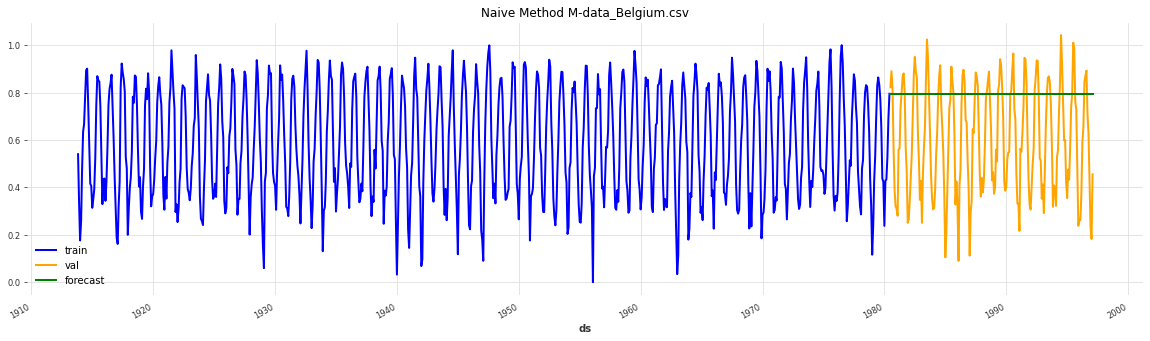

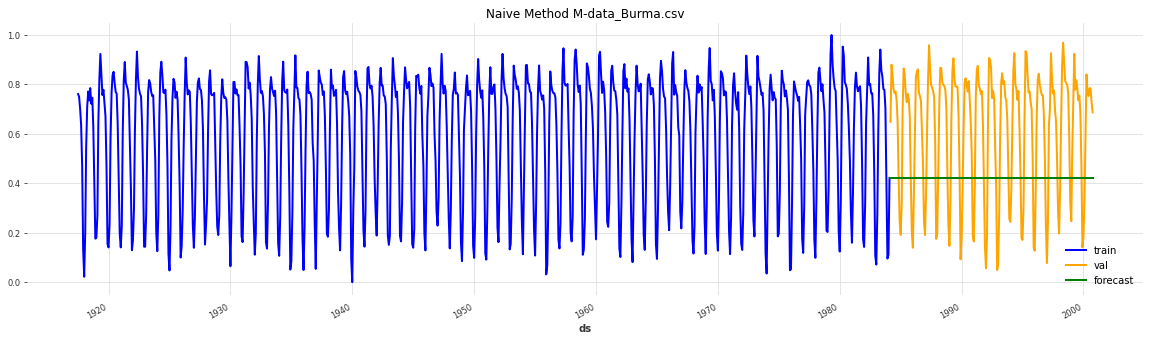

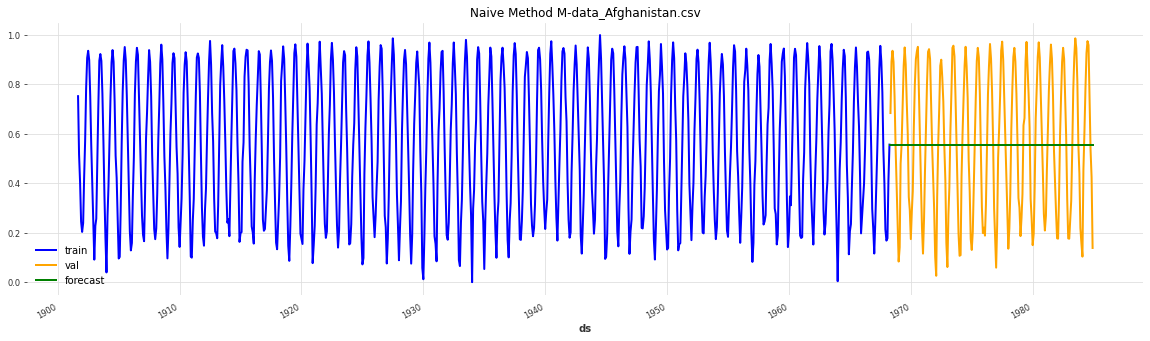

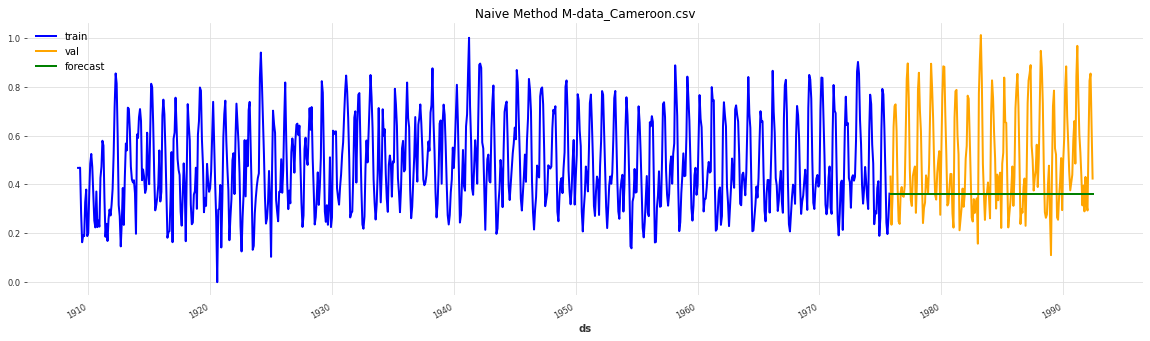

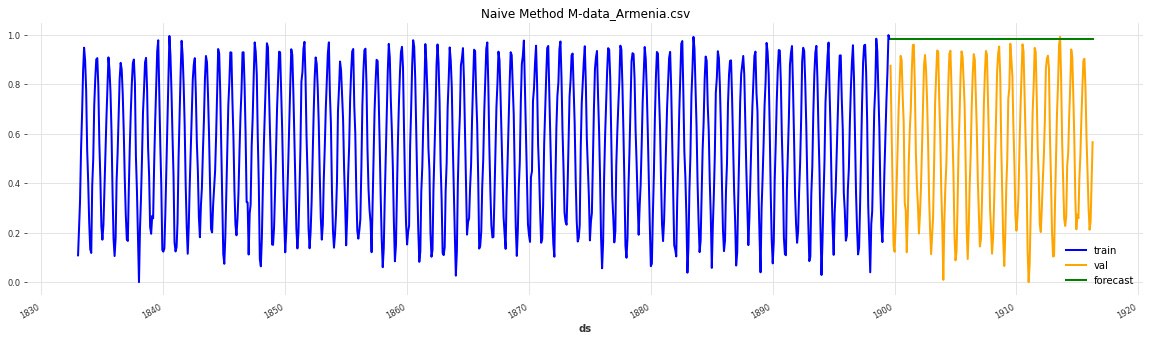

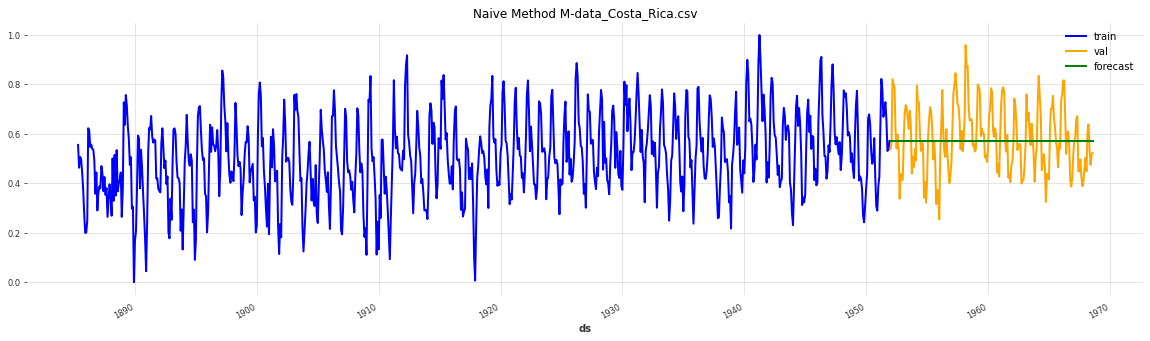

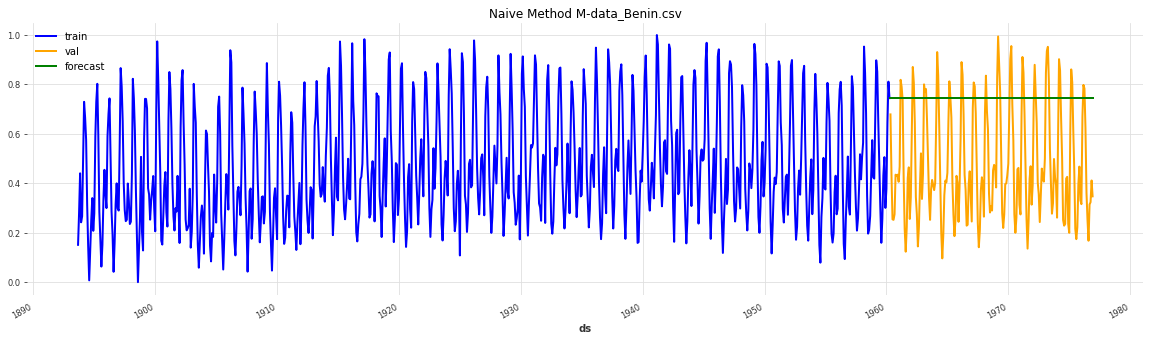

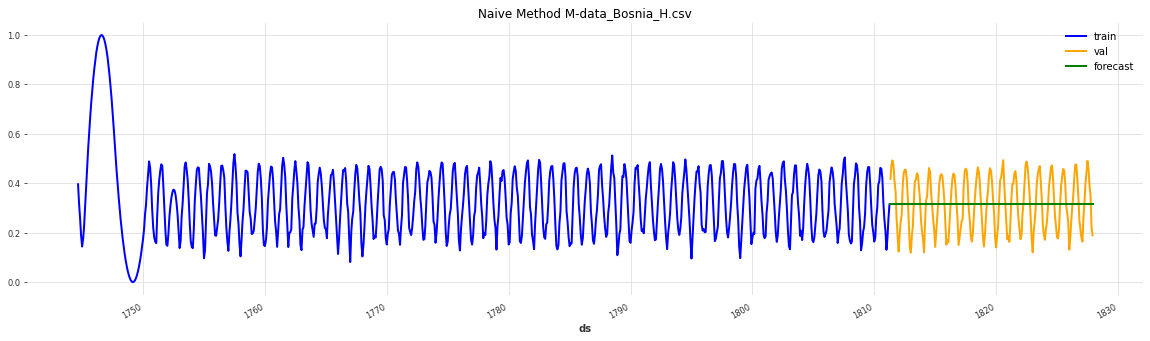

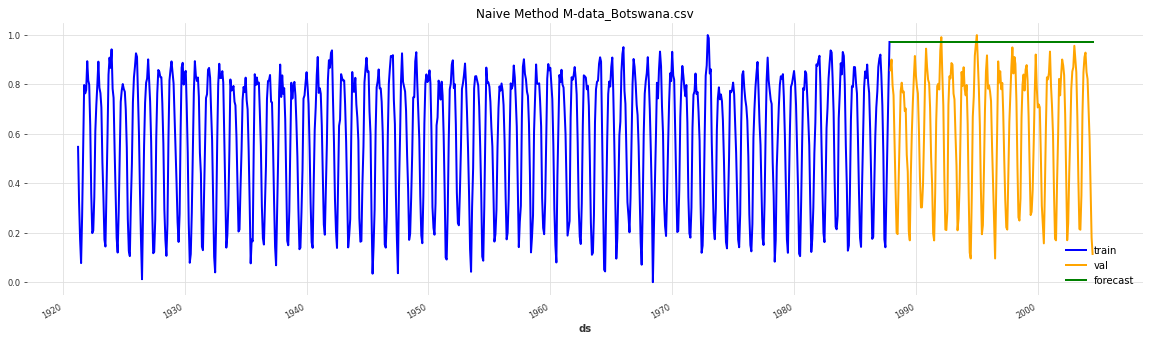

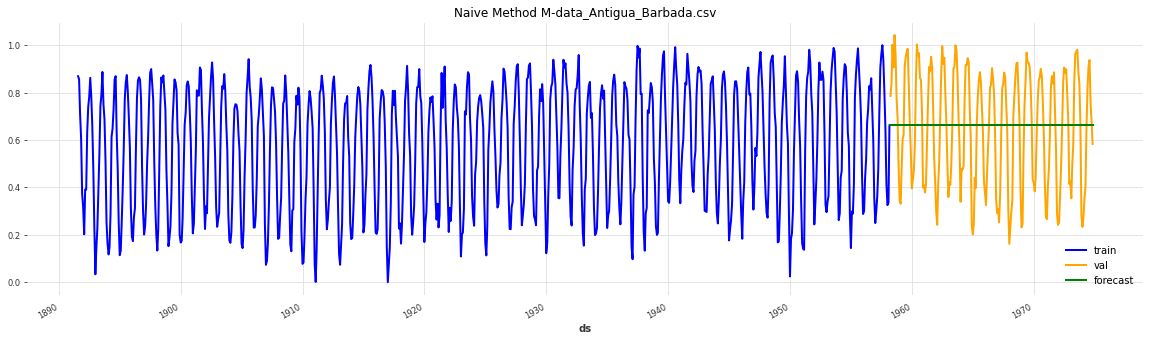

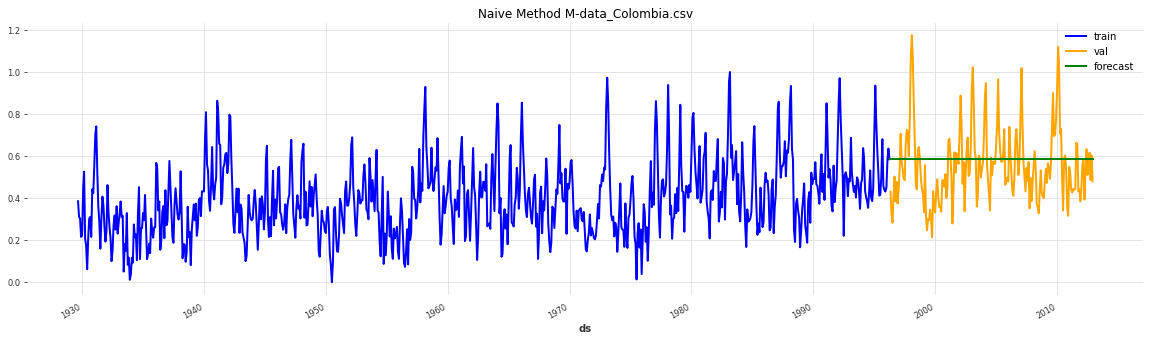

In [77]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

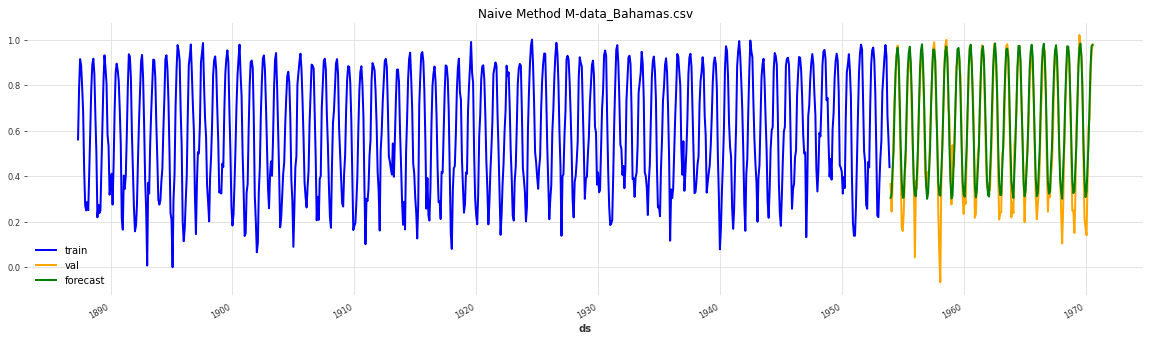

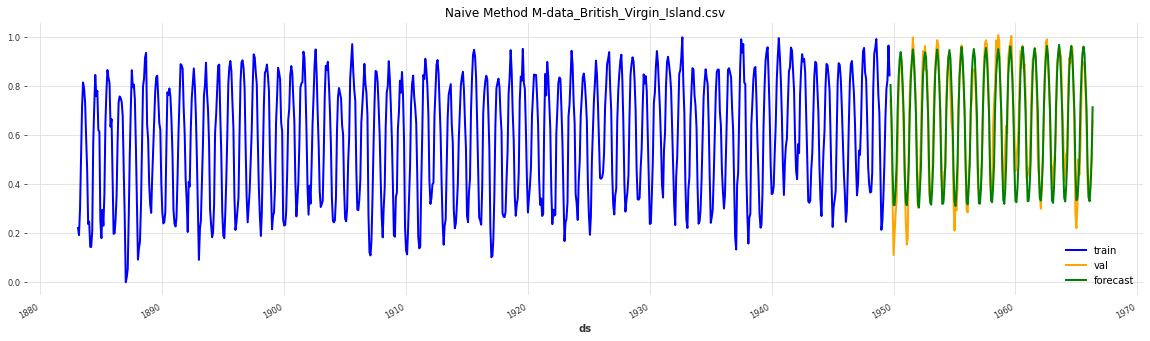

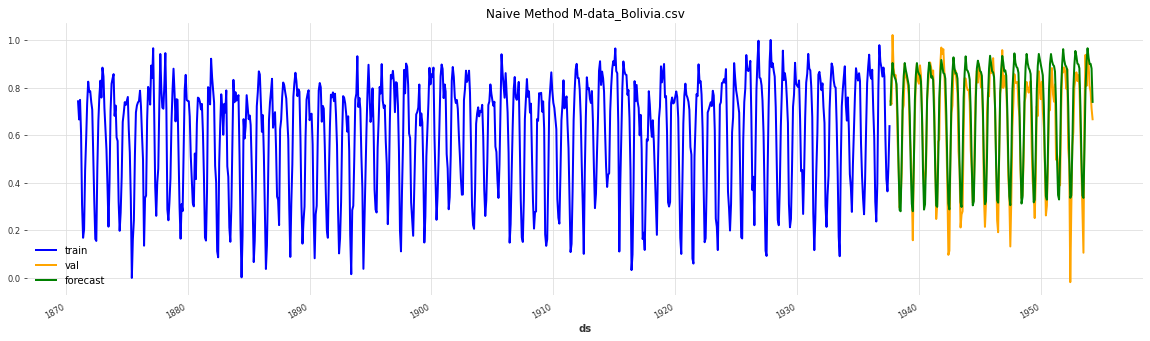

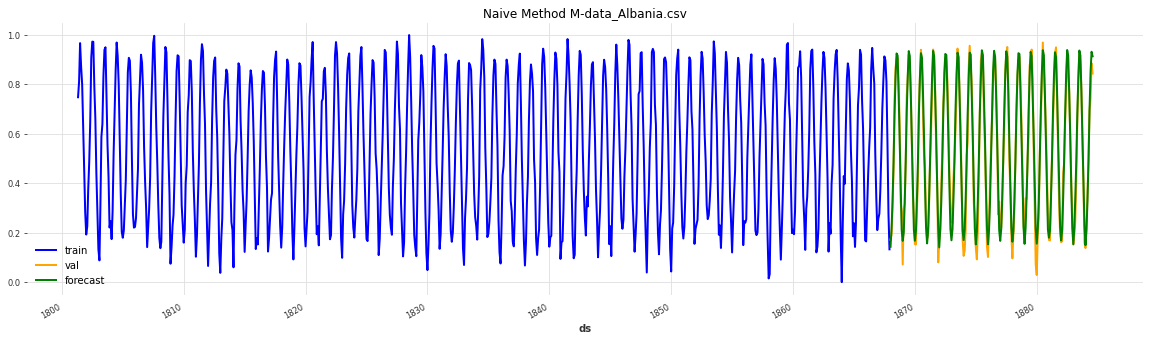

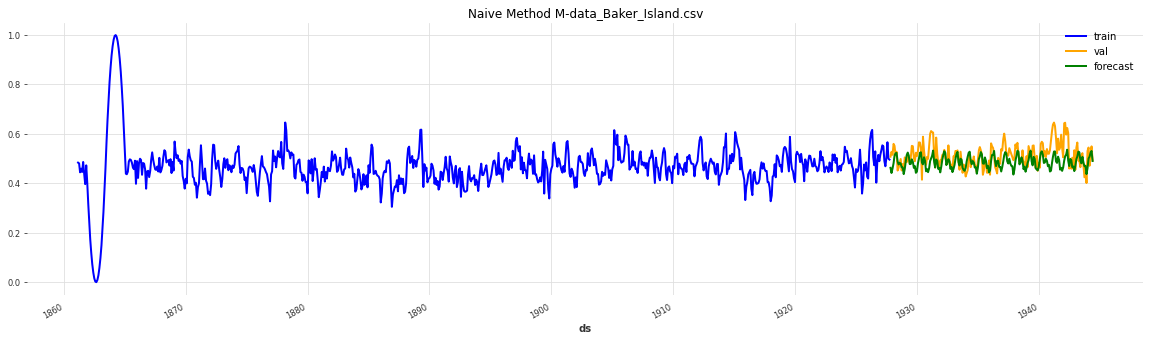

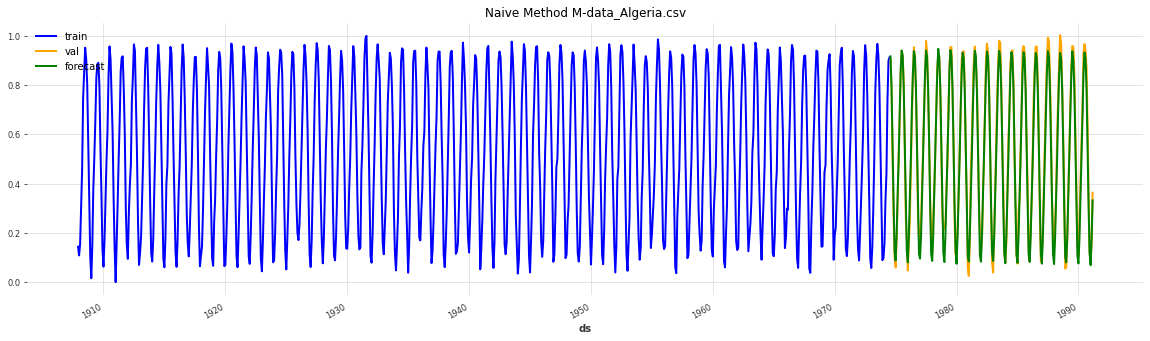

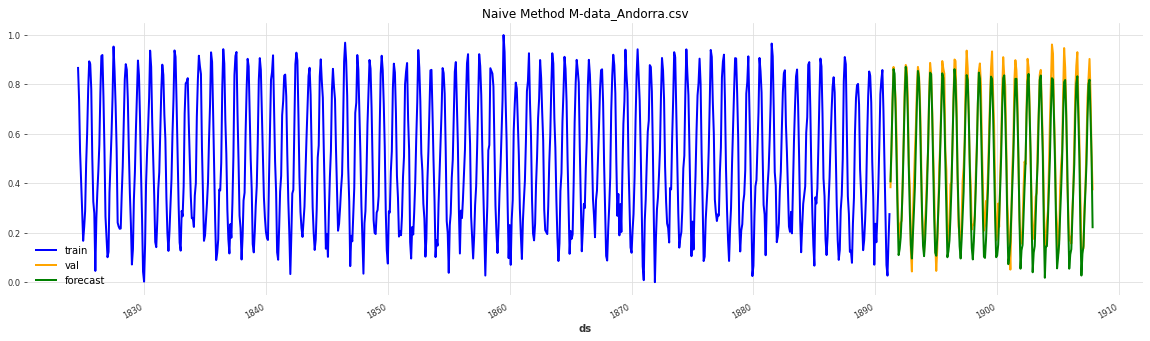

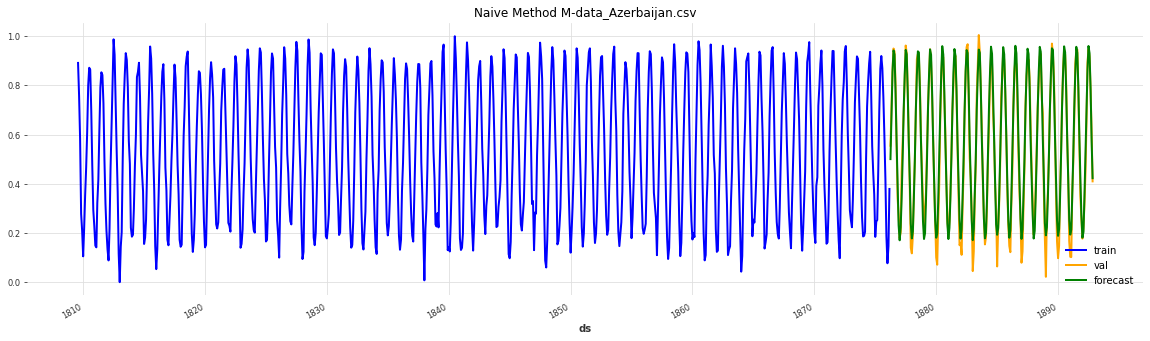

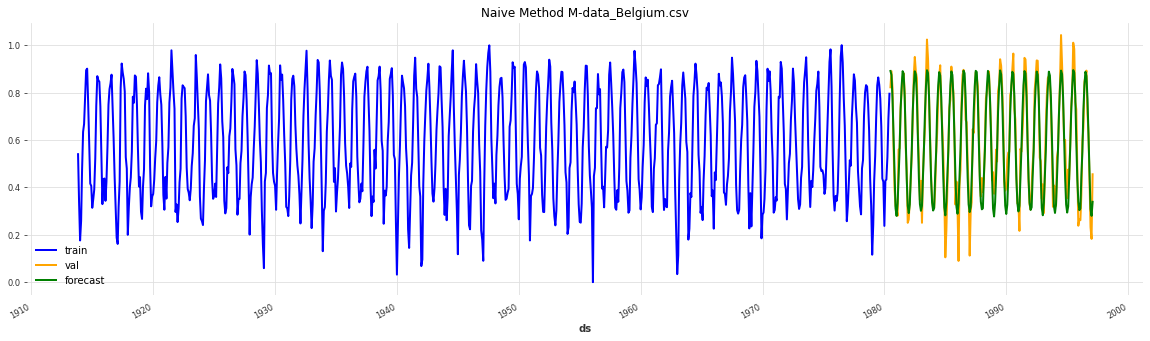

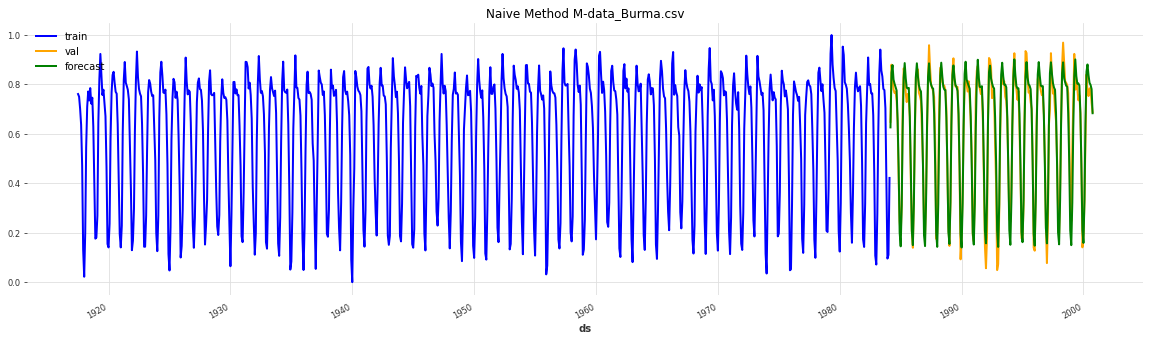

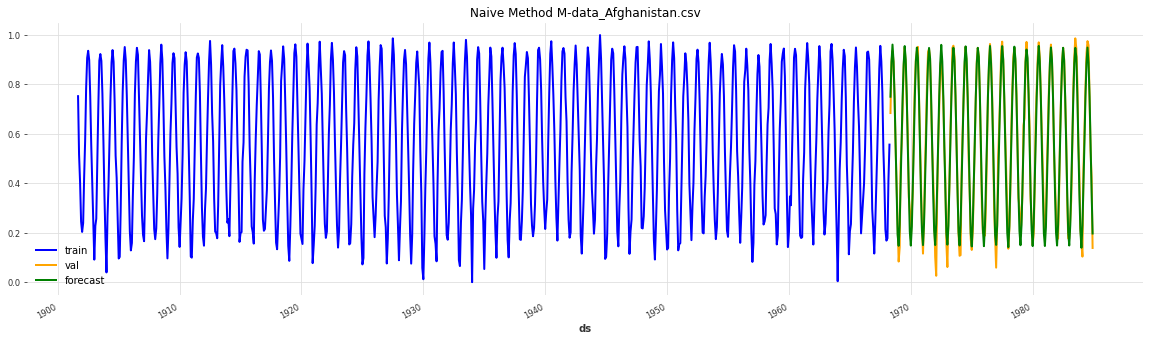

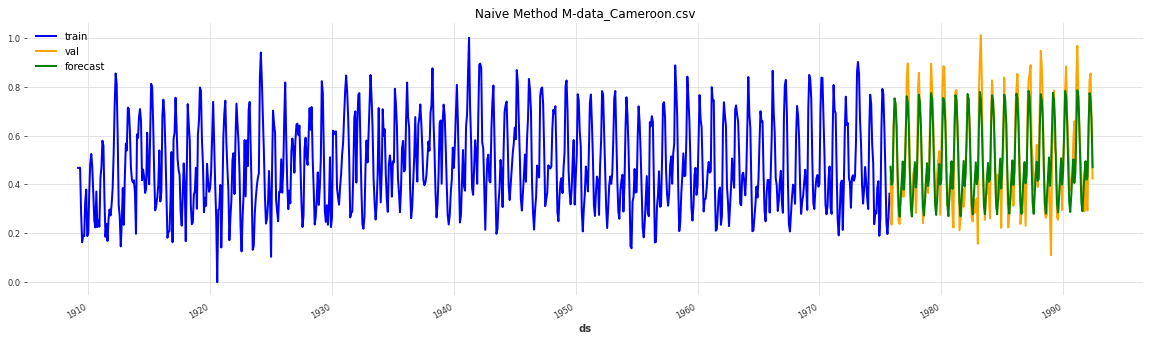

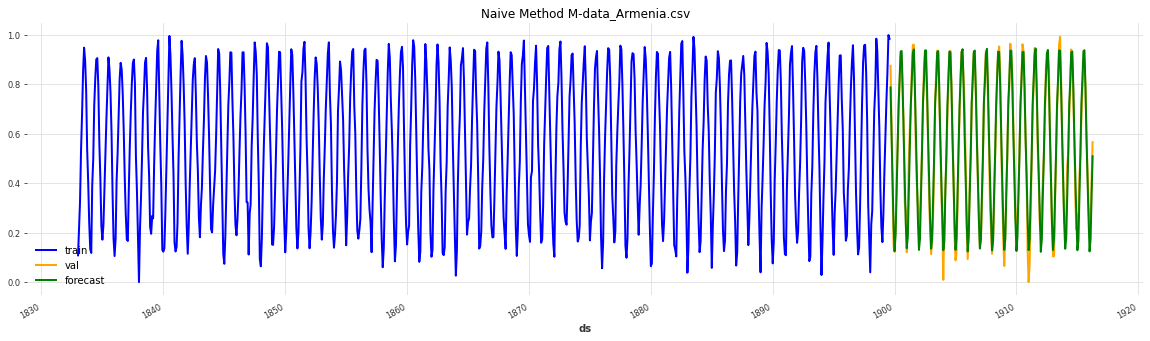

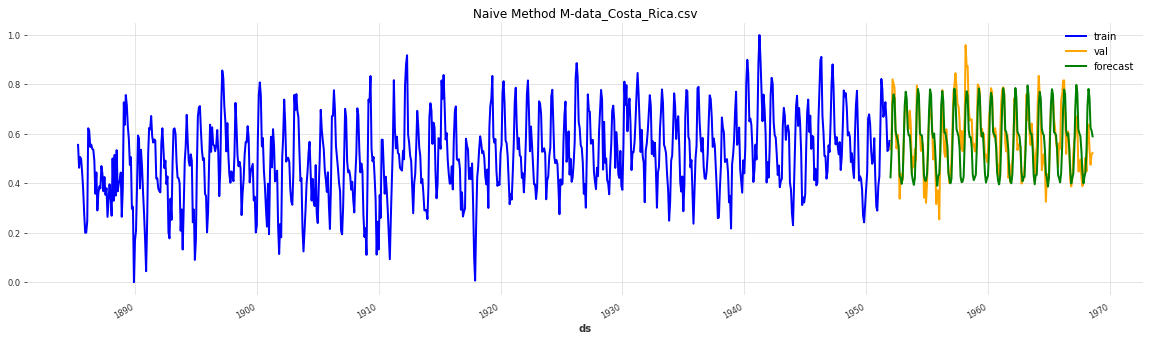

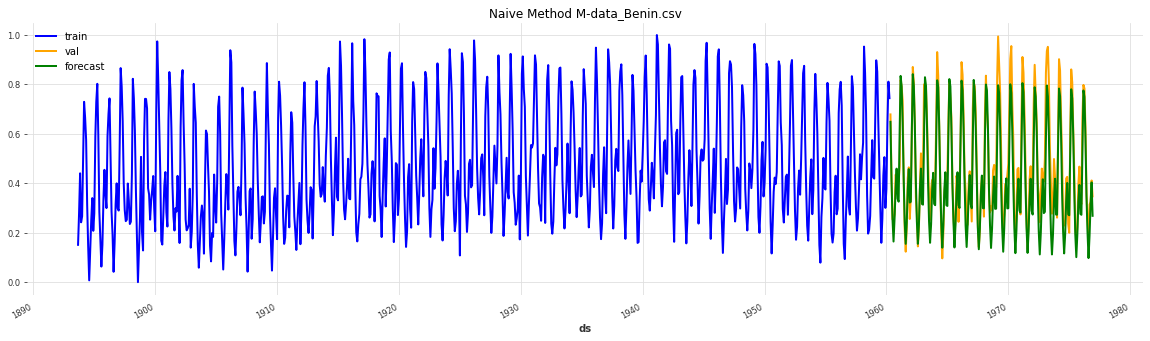

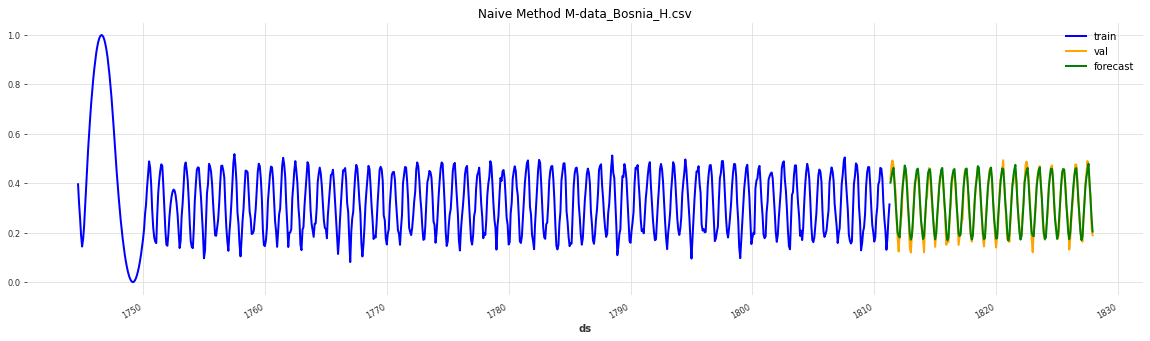

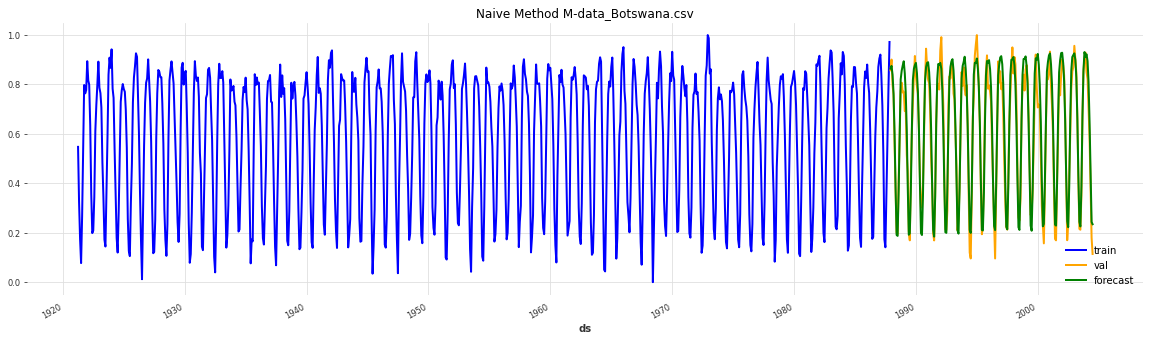

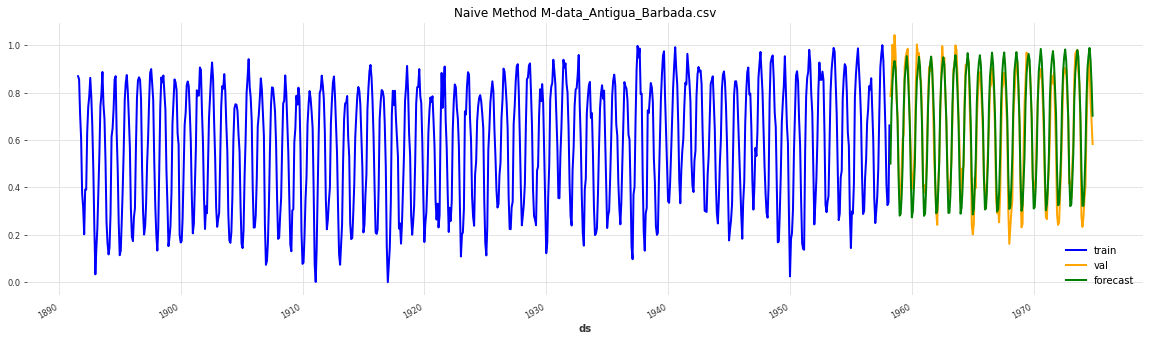

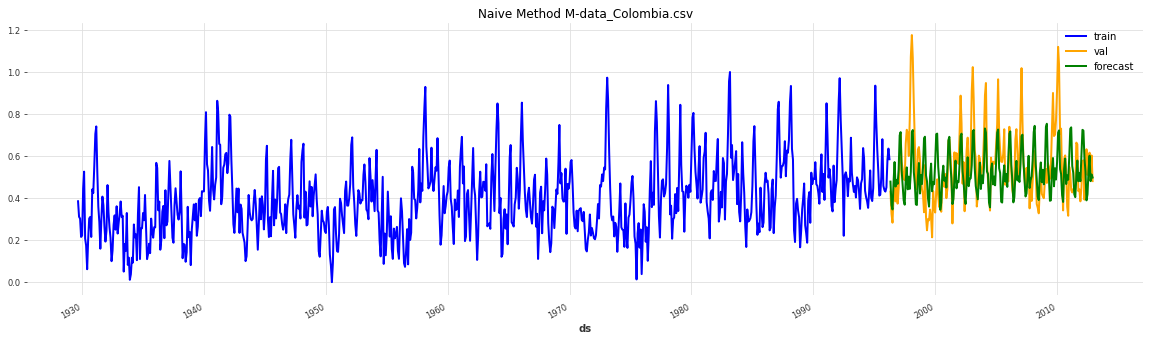

In [79]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [44]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 800 :
        print("ERROR, len(df_fit_naive[{}]) = {}".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 200 :
        print("ERROR, len(df_true_prediction_naive[{}]) = {}".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----


In [45]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 800 :
        print("ERROR, len(df_fit_prophet[{}]) = {}".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 200 :
        print("ERROR, len(df_true_prediction_prophet[{}]) = {}".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
Tout est bon pour data i =  16
-----
Tout est bon pour data i =  17
-----
Tout est bon pour data i =  18
-----
